## SOM & Agglomerative Clustering

In [1]:
import os
import pickle
import numpy as np

output_data_path = "output"

### Load Data

In [2]:
with open(
    os.path.join(output_data_path, "prominentHill_all_spectra_cr_cu.pkl"), "rb"
) as f:
    (all_spectra_cr, all_cu) = pickle.load(f)

In [3]:
with open("data/wvl_arr.pkl", "rb") as f:
    base_wvl_arr = pickle.load(f)
swir_wvl_base = base_wvl_arr[0].astype(float).values
tir_wvl_base = base_wvl_arr[1].astype(float).values

In [4]:
all_wvl_base = list(swir_wvl_base)+list(tir_wvl_base)
arr_all_wvl = np.array(all_wvl_base).reshape((-1,1))

#### Load Trained DAE Model

In [5]:
from spectraZones.networks import AutoEncoderModel

model_save_path = os.path.join("models", "DAE")

In [6]:
model = AutoEncoderModel.loadModelFile(
    save_path=model_save_path,
    model_name="prominentHill_autoencolder_all_cr",
)
print(model.nn)


-----------------------------------
Starting NN Model at device: cuda:0
-----------------------------------

AutoencoderNN(
  (encoder): Sequential(
    (lin_1): Linear(in_features=872, out_features=256, bias=True)
    (relu_1): ReLU(inplace=True)
    (lin_2): Linear(in_features=256, out_features=128, bias=True)
    (relu_2): ReLU(inplace=True)
    (lin_3): Linear(in_features=128, out_features=64, bias=True)
    (relu_3): ReLU(inplace=True)
    (lin_4): Linear(in_features=64, out_features=32, bias=True)
    (relu_4): ReLU(inplace=True)
    (lin_5): Linear(in_features=32, out_features=16, bias=True)
  )
  (decoder): Sequential(
    (lin_1): Linear(in_features=16, out_features=32, bias=True)
    (relu_1): ReLU(inplace=True)
    (lin_2): Linear(in_features=32, out_features=64, bias=True)
    (relu_2): ReLU(inplace=True)
    (lin_3): Linear(in_features=64, out_features=128, bias=True)
    (relu_3): ReLU(inplace=True)
    (lin_4): Linear(in_features=128, out_features=256, bias=True)
    (r

#### Encode Data

In [7]:
encoded_spectra_cr = model.encode(all_spectra_cr)

#### Apply MDVPT

In [9]:
from spectraZones.tools.MDVPT import MDVPTTransform

mdvpt_model_path = os.path.join("models", "MDVPT")
os.makedirs(mdvpt_model_path, exist_ok=True)

In [10]:
mdvpt = MDVPTTransform(name="prominentHill_all_cr_mdvpt", output_dir=mdvpt_model_path)

In [ ]:
# mdvpt.load()

In [11]:
mdvpt_all_cr = mdvpt.fit_transform(encoded_spectra_cr)
# mdvpt_all_cr = mdvpt.transform(encoded_spectra_cr)

Processing samples:   0%|          | 0/16 [00:00<?, ?it/s]

In [12]:
print("MDVPT Drill Hole Data Samples: ", mdvpt_all_cr.shape[0])
print("MDVPT Drill Hole Data Features: ", mdvpt_all_cr.shape[1])

MDVPT Drill Hole Data Samples:  219363
MDVPT Drill Hole Data Features:  16


##### Save MDVPT transformed data

In [13]:
with open(
    os.path.join(output_data_path, "prominentHill_mdvpt_all_cr_np.npy"), "wb"
) as f:
    np.save(f, mdvpt_all_cr)

##### Load MDVPT transformed data

In [32]:
with open(
    os.path.join(output_data_path, "prominentHill_mdvpt_all_cr_np.npy"), "rb"
) as f:
    mdvpt_all_cr = np.load(f)

#### Training SOM

In [9]:
from quicksom.som import SOM

# Save model path
som_model_path = os.path.join("models", "SOM")
os.makedirs(som_model_path, exist_ok=True)


In [10]:
# SOM Hyperparameters
m, n = 50, 50
dim = mdvpt_all_cr.shape[1]
n_epoch = 30
batch_size = 256

In [11]:
# Initialize model
som = SOM(m, n, dim, n_epoch=n_epoch, alpha=2, device="cuda") # remove device parameter if cuda is not available

In [18]:
# Train model
learning_error = som.fit(mdvpt_all_cr, batch_size=batch_size)

# Save model
som.save_pickle(
    os.path.join(som_model_path, "prominentHill_som_all_cr_mdvpt_50x50.pkl")
)

1/30: 0/6580890 | alpha: 2.000000 | sigma: 25.000000 | error: 2.035016 | time: 0:01:15.033350 | eta: 22 days, 7:46:17.396429
1/30: 25600/6580890 | alpha: 1.992220 | sigma: 24.902749 | error: 0.382952 | time: 0:01:15.374387 | eta: 5:18:28.975410
1/30: 51200/6580890 | alpha: 1.984440 | sigma: 24.805497 | error: 0.360182 | time: 0:01:15.470361 | eta: 2:39:36.701268
1/30: 76800/6580890 | alpha: 1.976660 | sigma: 24.708246 | error: 0.343772 | time: 0:01:15.557593 | eta: 1:46:17.362426
1/30: 102400/6580890 | alpha: 1.968880 | sigma: 24.610995 | error: 0.373107 | time: 0:01:15.647715 | eta: 1:19:33.842712
1/30: 128000/6580890 | alpha: 1.961099 | sigma: 24.513744 | error: 0.357279 | time: 0:01:15.736448 | eta: 1:03:30.344759
1/30: 153600/6580890 | alpha: 1.953319 | sigma: 24.416492 | error: 0.378663 | time: 0:01:15.826165 | eta: 0:52:47.489994
1/30: 179200/6580890 | alpha: 1.945539 | sigma: 24.319241 | error: 0.348685 | time: 0:01:15.911424 | eta: 0:45:07.861391
1/30: 204800/6580890 | alpha: 1

In [ ]:
# # Load trained model
# som = som.load_pickle(
#     os.path.join(som_model_path, "prominentHill_som_all_cr_mdvpt_50x50.pkl")
# )

##### Apply SOM to Drill Hole Data

In [31]:
from spectraZones.tools.agg_som import agg_cluster_som

In [33]:
som_pred = som.predict(mdvpt_all_cr.astype(np.float32))

0/2194 | time: 0:01:14.310941 
100/2194 | time: 0:01:14.454592 
200/2194 | time: 0:01:14.543011 
300/2194 | time: 0:01:14.619770 
400/2194 | time: 0:01:14.689635 
500/2194 | time: 0:01:14.750147 
600/2194 | time: 0:01:14.817696 
700/2194 | time: 0:01:14.885649 
800/2194 | time: 0:01:14.952582 
900/2194 | time: 0:01:15.020176 
1000/2194 | time: 0:01:15.085892 
1100/2194 | time: 0:01:15.385985 
1200/2194 | time: 0:01:15.447898 
1300/2194 | time: 0:01:15.507178 
1400/2194 | time: 0:01:15.565258 
1500/2194 | time: 0:01:15.621087 
1600/2194 | time: 0:01:15.678512 
1700/2194 | time: 0:01:15.734963 
1800/2194 | time: 0:01:15.795267 
1900/2194 | time: 0:01:15.854406 
2000/2194 | time: 0:01:15.912004 
2100/2194 | time: 0:01:15.970408 


##### Perform Agglomerative Clustering

In [34]:
som = agg_cluster_som(som)

In [ ]:
predicted_clusts, errors = som.predict_cluster(mdvpt_all_cr.astype(np.float32))

##### Save predicted clusters

In [23]:
with open(
    os.path.join(
        output_data_path, "promintHill_all_spectra_cr_encoded_mdvpt_clusters.pkl"
    ),
    "wb",
) as f:

    pickle.dump(predicted_clusts, f, protocol=pickle.HIGHEST_PROTOCOL)

In [36]:
with open(
    os.path.join(
        output_data_path, "promintHill_all_spectra_cr_encoded_mdvpt_clusters.pkl"
    ),
    "rb",
) as f:
    predicted_clusts = pickle.load(f)

#### Plot SOM Results

In [37]:
from spectraZones.tools.colors import k_colors
from matplotlib.colors import LinearSegmentedColormap

# Make Cluster Color Map
k_cmap = LinearSegmentedColormap.from_list(
    "clusters",
    k_colors,
    len(k_colors),
)

In [38]:
from spectraZones.tools.plot_som import make_color_matrix, plot_som_results

In [39]:
cu_color_mat = make_color_matrix(som.umat.shape, som_pred[0], all_cu)

In [40]:
clusters_color_mat = make_color_matrix(
    som.umat.shape, som_pred[0], predicted_clusts, np.bincount, np.argmax
)

In [41]:
output_images_path = "imgs/"
os.makedirs(output_images_path, exist_ok=True)

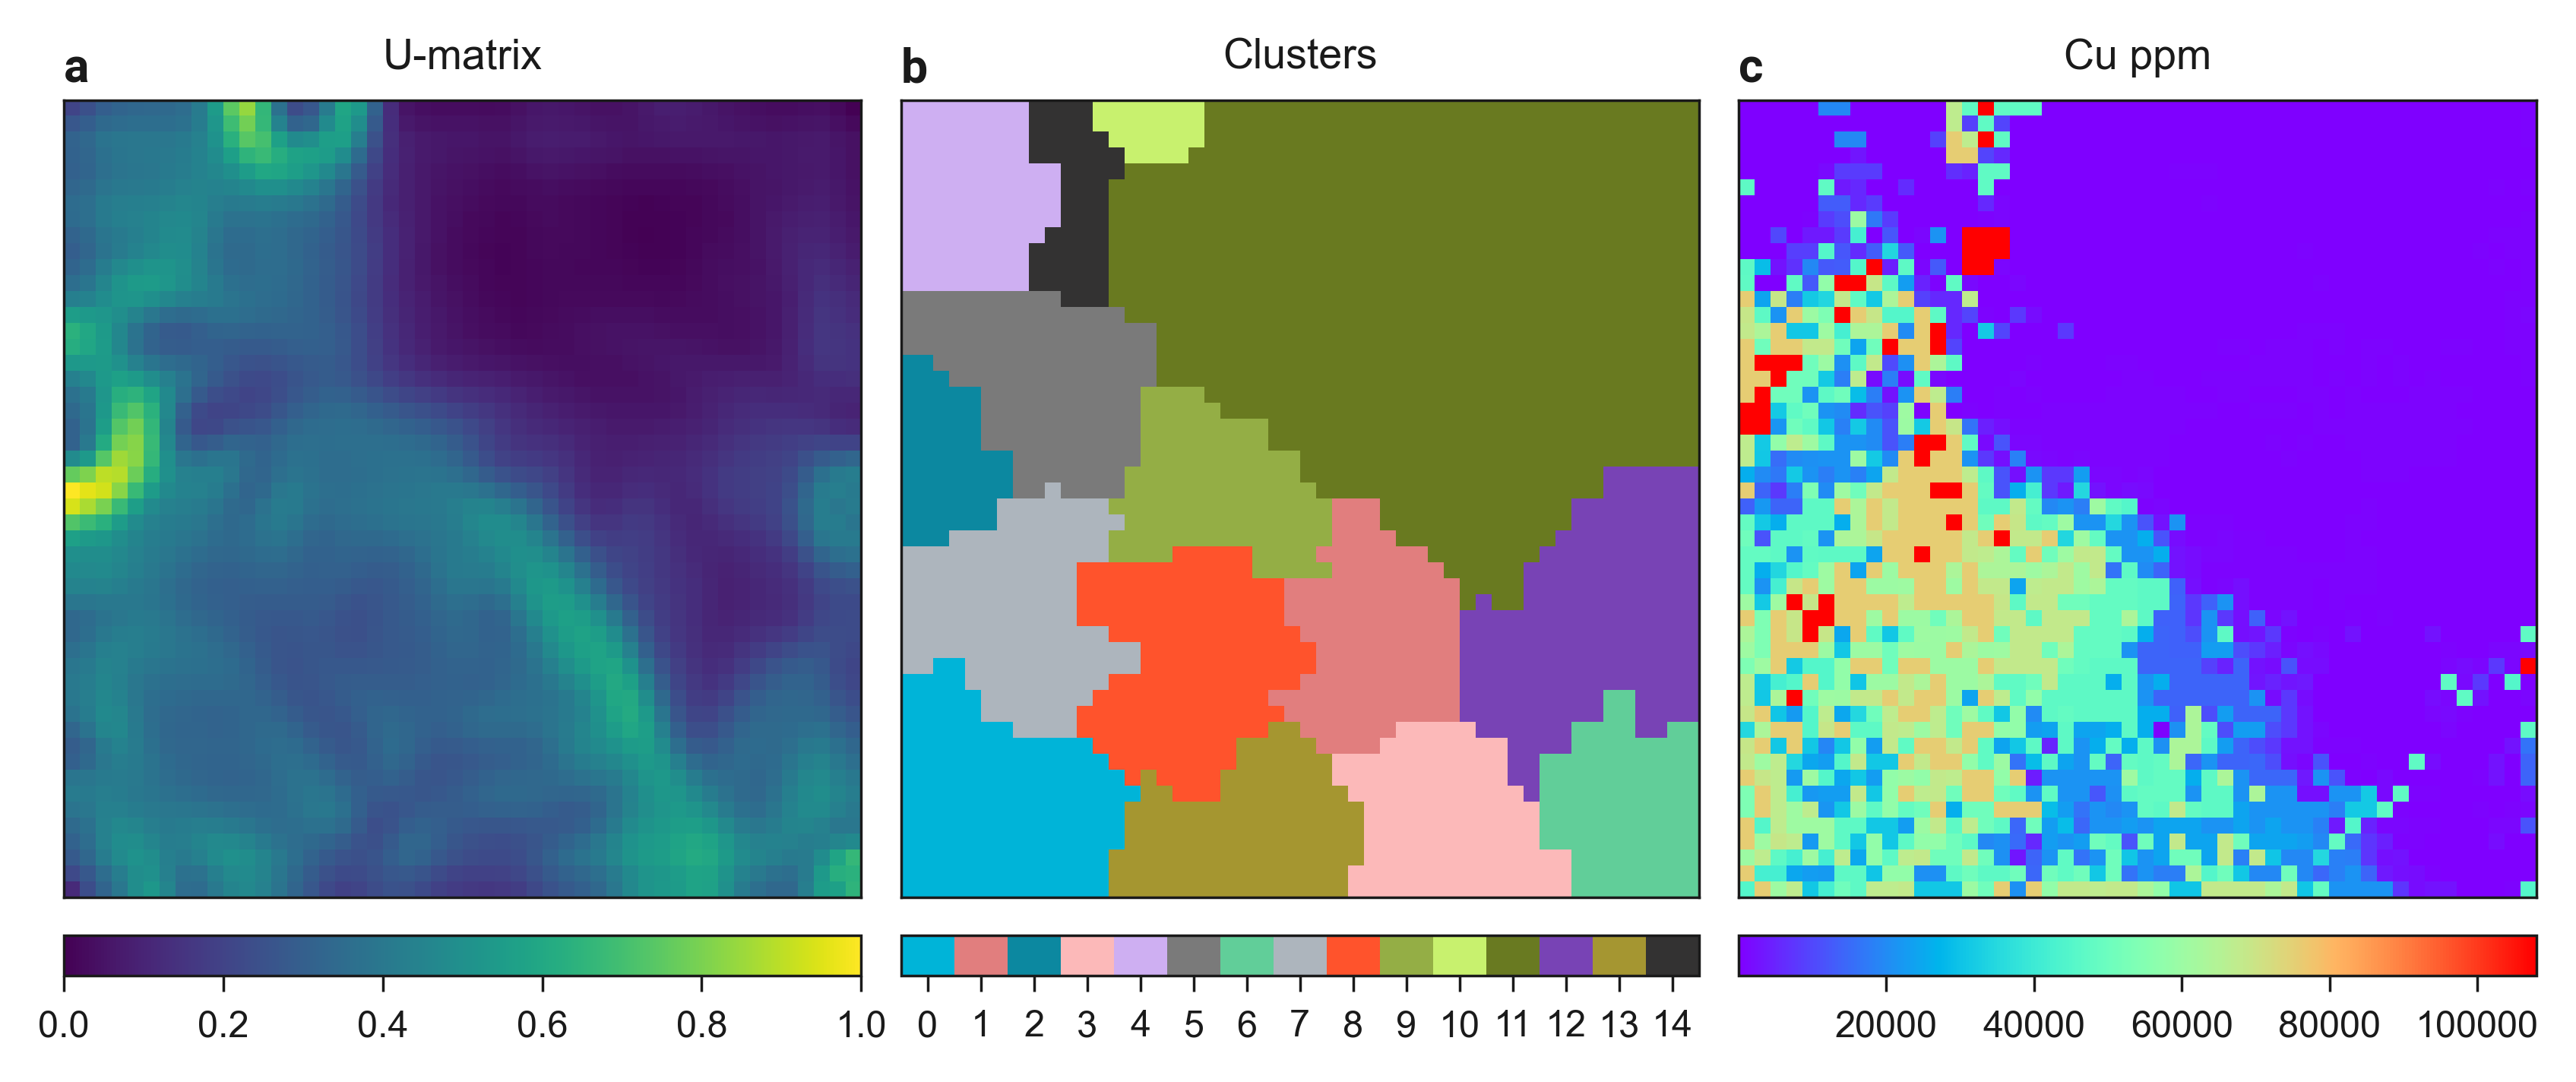

In [42]:
plot_som_results(
    som.umat,
    cu_color_mat,
    clusters_color_mat,
    clusters_cmap=k_cmap,
    figname=os.path.join(output_images_path, "som_results_fig.png"),
    dpi=500,
    legend_size=7,
)